In [7]:
import os, sys
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
file_3pt_shooting = '../Data/nba_3pt_progressions_all_players.json'
with open(file_3pt_shooting, 'r') as f:
    data_3pt_shooting = json.load(f)
    f.close()

In [3]:
print(data_3pt_shooting[0])

{'name': 'Álex Abrines', 'url': 'https://www.basketball-reference.com/players/a/abrinal01.html', 'row_data': [{'age': '23', 'fg3': '94', 'fg3a': '247', 'fg3_pct': '.381'}, {'age': '24', 'fg3': '84', 'fg3a': '221', 'fg3_pct': '.380'}, {'age': '25', 'fg3': '41', 'fg3a': '127', 'fg3_pct': '.323'}]}


In [4]:
## Need to create a dataframe with the following columns
##  name                              - will be the 'units' value for sns.lineplot
##  season, as a zero'd out age value - will be the x axis
##  fg3
##  fg3a
##  fg3_pct                           - will be the y axis

## To Do:
##  [x] fix the issue with multiple rows when a player was on more than 1 team in a single season
##  [ ] don't include players with only 1 entry. Could be something to fix on the previous stage

records_3pt_shooting = []
for row in data_3pt_shooting:
    #print (row)
    name = row['name']
    min_age = min([int(x['age']) for x in row['row_data']])
    prev_age = 0
    for season in row['row_data']:
        year = int(season['age']) - min_age
        fg3 = float(season['fg3'].replace('<strong>','').replace('</strong>',''))
        fg3a = float(season['fg3a'].replace('<strong>','').replace('</strong>',''))
        fg3_pct = float(season['fg3_pct'].replace('<strong>','').replace('</strong>',''))
        if fg3a > 25 and prev_age!=season['age']:
            records_3pt_shooting.append({
                'name': name,
                'year': year,
                'fg3': fg3,
                'fg3a': fg3a,
                'fg3_pct': fg3_pct,
            })
        prev_age = season['age']

df_3pt_shooting = pd.DataFrame(records_3pt_shooting)

### Downselect the player 3pt shooting dataframe to only be the players with more then N data points of interest

In [5]:
## get the list of all name occurrences
all_name_occurrences = list(df_3pt_shooting['name'])

## create the frequency counts
name_frequencies_single = {}
name_frequencies_plural = {}
for x in all_name_occurrences:
    if x in name_frequencies_single.keys():
        if x in name_frequencies_plural:
            name_frequencies_plural[x] += 1
        else:
            name_frequencies_plural[x] = 2
    else:
        name_frequencies_single[x] = 1
        
##print (name_frequencies_plural)
## Create the list of player names with multiple points
names_plural = list(name_frequencies_plural.keys())

## Downselect the dataframe
df_3pt_shooting = df_3pt_shooting[df_3pt_shooting['name'].isin(names_plural)]
    

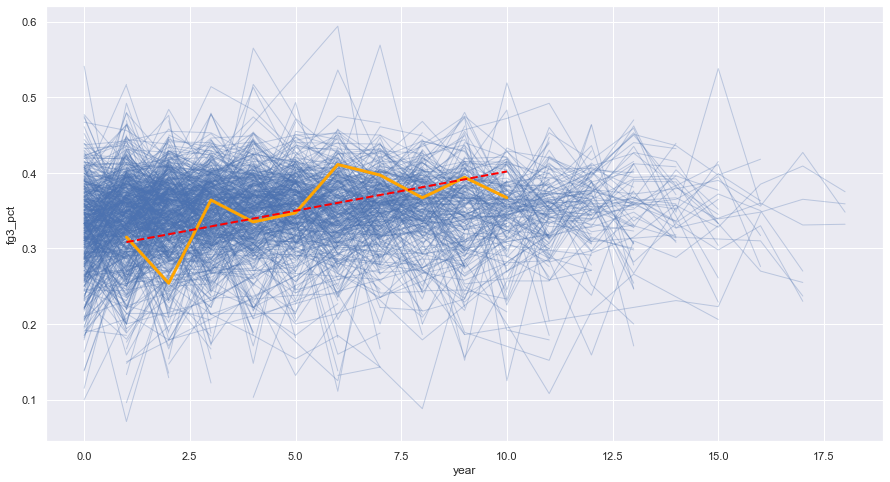

In [8]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.lineplot(
    data=df_3pt_shooting,
    x="year", y="fg3_pct", units="name",
    estimator=None, lw=1, alpha=0.3
)

player_highlight = 'Tobias Harris' #None
if player_highlight:
    df_3pt_shooting_player = df_3pt_shooting[df_3pt_shooting['name']==player_highlight]
    sns.lineplot(data=df_3pt_shooting_player,
        x="year", y="fg3_pct", units="name",
        estimator=None, lw=3, color='orange'
    )
    
    ## Plot the linear regression
    X = df_3pt_shooting_player['year'].values.reshape(-1, 1)
    Y = df_3pt_shooting_player['fg3_pct'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    #print (X, type(X))
    #print (Y_pred, type(Y_pred))
    sns.lineplot(x=X.reshape(1,-1)[0].tolist(), y=Y_pred.reshape(1,-1)[0].tolist(), 
                 lw=2, color='red', linestyle='--')

### Export the dataframe to csv for webapp use

In [9]:
df_3pt_shooting.to_csv('../Data/nba_3pt_progressions_dataframe.csv', index=False)

### Creating Linear Regressions For Each Player

To Do:
- [x] Save the coefficients to a dataframe/list/json/...
- [x] filter out the coefficients by a min/max boundry
- [ ] methodlogy for determining when the improvement occurs (if any)
- [ ] downsample the population to players with 3 data points

In [73]:
def get_lin_reg_coef(df_3pt_shooting, player_name):
    df_player = df_3pt_shooting[df_3pt_shooting['name']==player_name]
    
    X = df_player['year'].values.reshape(-1, 1)
    Y = df_player['fg3_pct'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    ## Y_pred = linear_regressor.predict(X)  # make predictions
    
    return linear_regressor.coef_[0][0]

In [74]:
regression_coefficients = []
for player in list(set(list(df_3pt_shooting['name']))):
    
    #print (player, get_lin_reg_coef(df_3pt_shooting, player))
    regression_coefficients.append((player, get_lin_reg_coef(df_3pt_shooting, player)))
    
##print (regression_coefficients)

## Split Regressions into improvement, meh, and decline
bound_inc = 0.01
bound_dec = -0.01
regression_improvement, regression_same, regression_decline = [], [], []
for x in regression_coefficients:
    if x[1] >= bound_inc:
        regression_improvement.append(x)
    elif x[1] >= bound_dec:
        regression_same.append(x)
    else:
        regression_decline.append(x)
        
print ('Improve:', len(regression_improvement))
print ('Same   :', len(regression_same))
print ('Decline:', len(regression_decline))

Improve: 180
Same   : 404
Decline: 164


In [59]:
## Make the same multi line plot, but just with improve/same/decline split out

df_3pt_improve = df_3pt_shooting[df_3pt_shooting['name'].isin([x[0] for x in regression_improvement])]
df_3pt_same = df_3pt_shooting[df_3pt_shooting['name'].isin([x[0] for x in regression_same])]
df_3pt_decline = df_3pt_shooting[df_3pt_shooting['name'].isin([x[0] for x in regression_decline])]

<AxesSubplot:xlabel='year', ylabel='fg3_pct'>

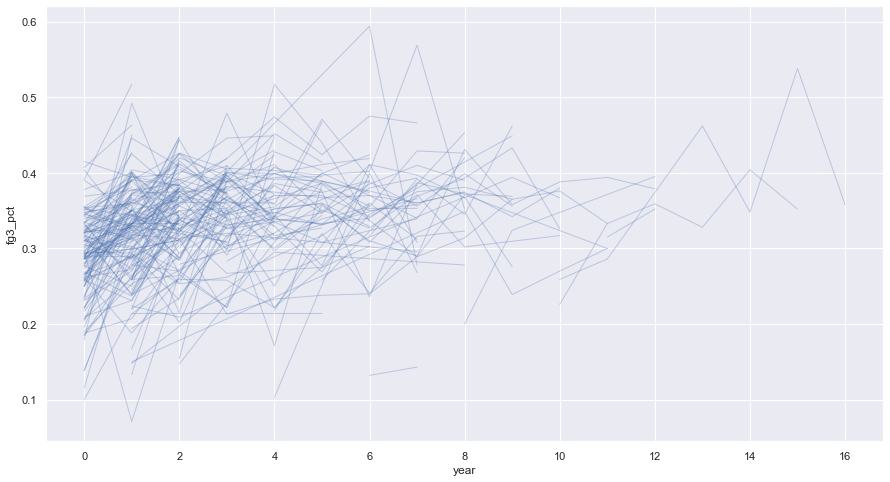

In [60]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.lineplot(
    data=df_3pt_improve,
    x="year", y="fg3_pct", units="name",
    estimator=None, lw=1, alpha=0.3
)

<AxesSubplot:xlabel='year', ylabel='fg3_pct'>

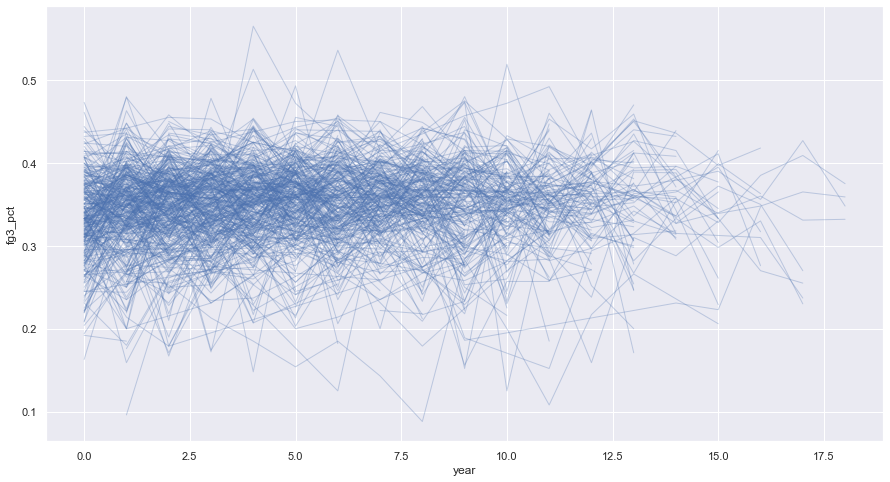

In [61]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.lineplot(
    data=df_3pt_same,
    x="year", y="fg3_pct", units="name",
    estimator=None, lw=1, alpha=0.3
)

<AxesSubplot:xlabel='year', ylabel='fg3_pct'>

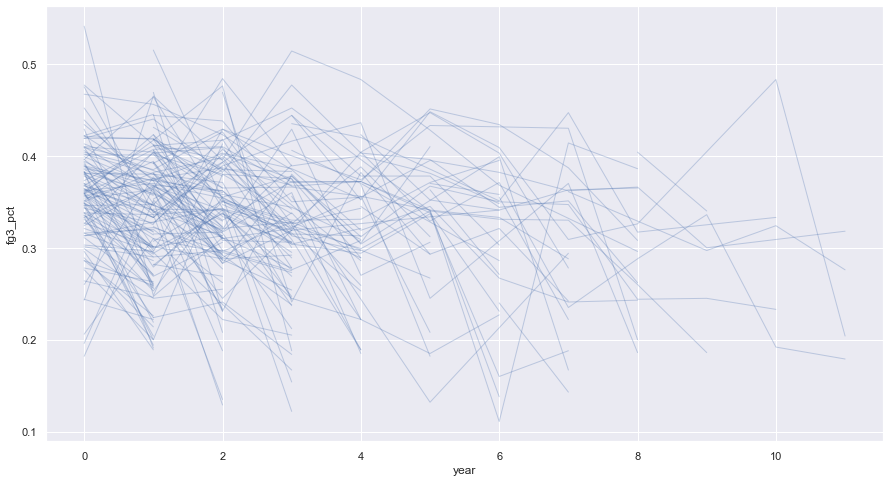

In [62]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.lineplot(
    data=df_3pt_decline,
    x="year", y="fg3_pct", units="name",
    estimator=None, lw=1, alpha=0.3
)